In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [281]:
data = pd.read_csv("Medicalpremium.csv")

In [317]:
df = data.copy()

# Custom transformers

In [279]:
class upsample(BaseEstimator, TransformerMixin):
    def __init__(self, category="NumberOfMajorSurgeries", cls=3, nSamples=100):
        self.category = category
        self.nSamples = nSamples
        self.cls = cls

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sample = resample(X[X[self.category] == self.cls], n_samples=self.nSamples, replace=True)
        X = pd.concat([X[X[self.category] != self.cls], sample])
        X.reset_index(drop=True, inplace=True)
        return X

In [5]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            X = X.drop(["Weight", "Height"], axis=1)
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    #X = X.drop(["Weight", "Height"], axis=1)
                    return X
            else:
                #X = X.drop(["Weight", "Height"], axis=1)
                return X
        else:
            return X

In [6]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [7]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
        self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

# preprocessing

In [357]:
dt = upsample(category= "NumberOfMajorSurgeries", cls=3, nSamples=100).transform(dt)

In [358]:
X = dt.drop("PremiumPrice", axis=1)
y = dt.PremiumPrice.copy()

In [359]:
X.shape

(1175, 10)

In [360]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [361]:
pipe = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler())
])

In [362]:
X_train = pipe.fit_transform(x_train.copy())
X_test = pipe.fit_transform(x_test.copy())

# Random Forest

In [363]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [364]:
forest_reg = RandomForestRegressor(random_state=42)

In [365]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [366]:
pred = forest_reg.predict(X_test)

In [367]:
np.sqrt(mean_squared_error(y_test, pred))

3497.96530523042

[0.00815467 0.00587371 0.15931776 0.07399952 0.00446861 0.01520862
 0.04852332 0.59185801 0.09259578]


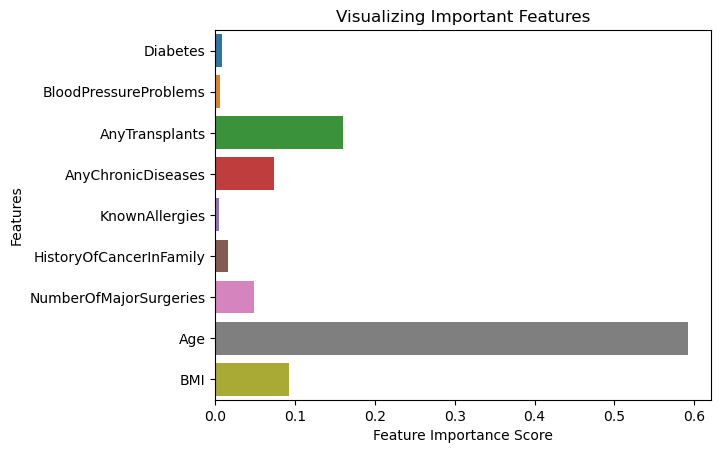

In [368]:
feature_imp1 = forest_reg.feature_importances_
print(feature_imp1)

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

[]

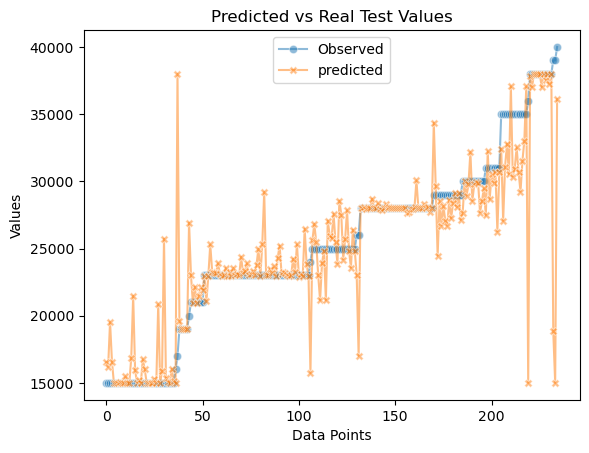

In [369]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed", marker='o', alpha=0.5)
sns.lineplot(temp.predicted, label="predicted", marker='X', alpha=0.5)
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

In [370]:
pred = forest_reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

903.2507486261038

## cross validation forest

In [371]:
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [372]:
forest_rmse_scores = np.sqrt(-scores)

In [373]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [374]:
display_scores(forest_rmse_scores)

Scores: [2645.17505353 2518.59488858 1508.97104579 3040.5855749  2301.9732516
 2472.11512505 2658.32774183 1679.53799372 2867.69293439 2719.83690062]
Mean: 2441.2810509995384
Standard deviation: 467.23202608640025


## hyperparameter forest

### RandomizedGridSearch

In [375]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [376]:
from sklearn.model_selection import RandomizedSearchCV

In [377]:
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(i) for i in np.linspace(10, 110, 11)]
max_depth.append(None)
min_sample_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

In [378]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [379]:
forest_reg = RandomForestRegressor()

In [380]:
forest_rgrid = RandomizedSearchCV(estimator=forest_reg,
                                  param_distributions=random_grid,
                                  cv=3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True,
                                  n_iter=100)

score = forest_rgrid.fit(X_train, y_train)

#### saving

In [381]:
import joblib

joblib.dump(score, "forest1.pkl")

In [36]:
score = joblib.load("forest1.pkl")

In [37]:
cvres = score.cv_results_

In [38]:
temp = pd.DataFrame(cvres['params'])
temp["rmse"] = np.sqrt(-cvres["mean_test_score"])
temp.sort_values("rmse").head(20)

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap,rmse
7,600,5,1,sqrt,60.0,False,3145.051387
24,1400,5,1,sqrt,80.0,False,3148.069194
21,1600,5,1,sqrt,70.0,False,3150.499203
32,800,5,1,sqrt,100.0,False,3155.334227
11,800,5,1,sqrt,90.0,False,3157.626644
20,1800,10,1,sqrt,30.0,False,3161.234199
73,400,5,1,log2,90.0,False,3163.198137
85,600,10,1,sqrt,40.0,False,3164.400386
68,1000,10,1,sqrt,80.0,False,3166.888603
16,600,5,2,log2,70.0,False,3168.495348


In [39]:
best_forest_rgrid = score.best_estimator_

In [40]:
pred = best_forest_rgrid.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

In [ ]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed")
sns.lineplot(temp.predicted, label="predicted")
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

In [ ]:
pred = best_forest_rgrid.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
score.best_params_

In [ ]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [5, 6, 7],
    'n_estimators': [600, 800, 1000, 1200]
}

In [ ]:
forest_reg = RandomForestRegressor()

In [ ]:
forest_grid = GridSearchCV(estimator = forest_reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
score = forest_grid.fit(X_train, y_train)

#### saving

joblib.dump(score, "forest2.pkl")

score = joblib.load("forest2.pkl")

In [ ]:
score.

In [ ]:
best_forest_grid = score.best_estimator_

In [ ]:
pred = best_forest_grid.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

In [ ]:
feature_imp1 = best_forest_grid.feature_importances_


sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed")
sns.lineplot(temp.predicted, label="predicted")
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

# AdaBoost

In [342]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [343]:
Dtree = DecisionTreeRegressor(max_depth=1)
model = AdaBoostRegressor(n_estimators=50, base_estimator=Dtree, learning_rate=0.5)

In [344]:
model

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.5)

In [345]:
model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.5)

In [346]:
pred = model.predict(X_test)

In [347]:
np.sqrt(mean_squared_error(y_test, pred))

5028.391760988843

# XGBoost


In [382]:
import xgboost as xgb

In [383]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [384]:
xgb_scores = cross_val_score(model, X_train, y_train, 
                             scoring='neg_mean_squared_error',
                             cv=5, n_jobs=-1)

In [385]:
np.sqrt(-xgb_scores)

array([2959.54789201, 2609.2449329 , 2817.96097927, 2251.85671054,
       2734.31158961])

In [386]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [387]:
pred = model.predict(X_test)

In [388]:
np.sqrt(mean_squared_error(y_test, pred))

3611.437128754425

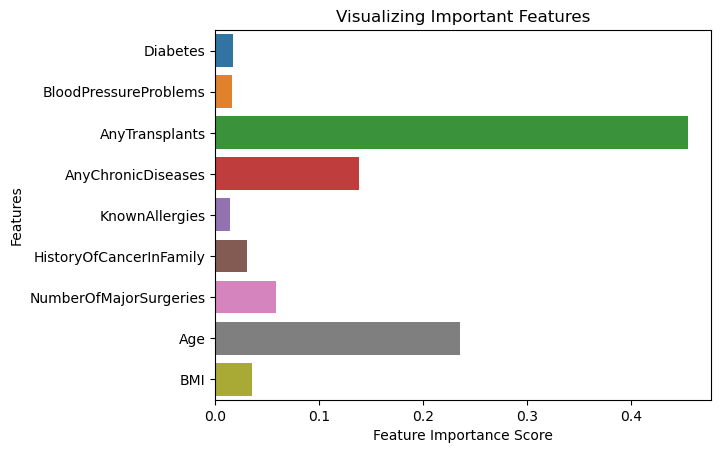

In [389]:
feature_imp1 = model.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

[]

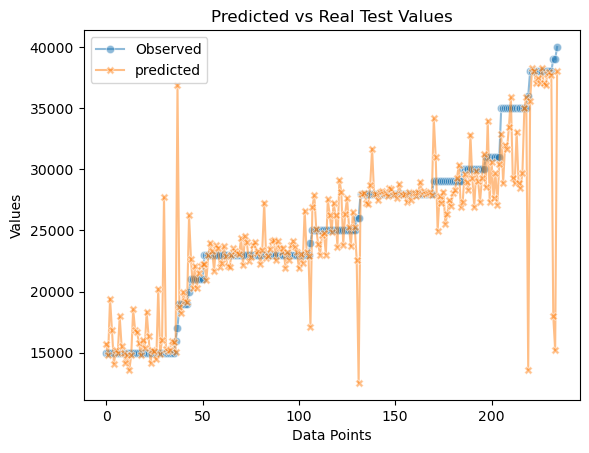

In [390]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

sns.lineplot(temp.Observed, label="Observed", marker='o', alpha=0.5)
sns.lineplot(temp.predicted, label="predicted", marker='X', alpha=0.5)
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Predicted vs Real Test Values')
plt.plot()

In [391]:
scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [392]:
scores = np.sqrt(-scores)

In [393]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [394]:
display_scores(scores)

Scores: [2507.22551536 2657.42832652 1809.81011389 3150.86062263 2423.8004778
 2838.27029112 2690.23952701 1914.93047173 2945.92734102 2550.10572414]
Mean: 2548.859841123358
Standard deviation: 400.12960887007193
